In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import timedelta

In [3]:
# 讀取資料
file_path = 'output.csv'
data = pd.read_csv(file_path)
data

,Order_ID,commodity,unit_price,quantity,time
0,1,肉骨湯麵,15,1,1692198875000000000
1,1,益生菌,150,15,1692198875000000000
2,1,原萃綠茶,39,2,1692198875000000000
3,1,品客洋芋片,60,5,1692198875000000000
4,2,肉骨湯麵,15,5,1692199562000000000
...,...,...,...,...,...
43667,17427,品客洋芋片,60,12,1723668693000000000
43668,17428,肉骨湯麵,15,17,1723669040000000000
43669,17428,原萃綠茶,39,6,1723669040000000000
43670,17428,益生菌,150,3,1723669040000000000


In [4]:
# 計算每個訂單的營業額
data['time'] = pd.to_datetime(data['time'], unit='ns')

# 計算每日來客數（每個Order_ID代表一個顧客）
daily_customers = data.groupby(data['time'].dt.date)['Order_ID'].nunique().reset_index()
daily_customers

,time,Order_ID
0,2023-08-16,6
1,2023-08-17,49
2,2023-08-18,47
3,2023-08-19,50
4,2023-08-20,30
...,...,...
360,2024-08-10,43
361,2024-08-11,57
362,2024-08-12,56
363,2024-08-13,42


In [5]:
# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_customers['Order_ID'].values.reshape(-1, 1))

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    print(f"Generated {len(X)} sequences.")
    return np.array(X), np.array(Y)


In [6]:
# 準備訓練資料
time_step = 5
X, Y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

Generated 359 sequences.


In [7]:
# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X, Y, batch_size=1, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# 保存模型到文件
model.save("Daily_Customer_Prediction.h5")

Epoch 1/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0767 - val_loss: 0.0292
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0200 - val_loss: 0.0383
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0270 - val_loss: 0.0272
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0256 - val_loss: 0.0287
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0267 - val_loss: 0.0258
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0269 - val_loss: 0.0259
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0245 - val_loss: 0.0258
Epoch 8/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0244 - val_loss: 0.0265
Epoch 9/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0245 - val_loss: 0.0274
Epoch 10/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0235 - val_loss: 0.0257
Epoch 11/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0253 - val_loss: 0.0257
Epoch 12/100
287/287 ━━━━━━━━━━━━━━━━━━━

In [17]:
# 預測未來的來客數
future_steps = 7
last_days = scaled_data[-time_step:]
pred_input = last_days.reshape(1, time_step, 1)
predictions = []

for _ in range(future_steps):
    pred = model.predict(pred_input)
    predictions.append(pred[0, 0])
    # 將 pred 重塑為 (1, 1, 1) 的 3D 数组
    pred = pred.reshape(1, 1, 1)
    # 更新 pred_input 的數據
    pred_input = np.append(pred_input[:, 1:, :], pred, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# 將預測結果轉換回原始範圍
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
# predictions = scaler.inverse_transform(pred)
predictions

array([[48.221577],
       [48.218994],
       [48.11129 ],
       [48.051674],
       [48.15166 ],
       [48.207325],
       [48.207867]], dtype=float32)

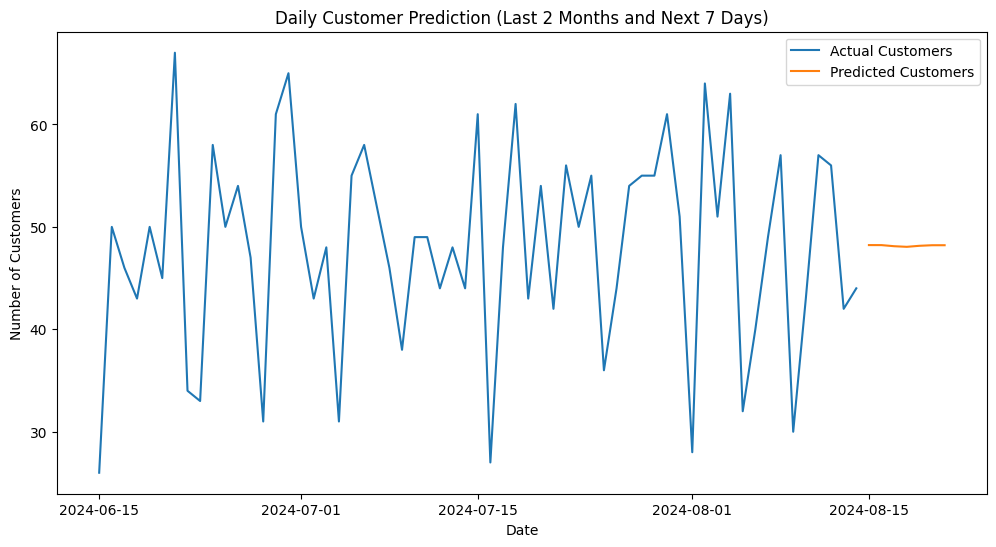

In [19]:
# 生成未來7天的日期範圍
future_dates = pd.date_range(start=daily_customers['time'].iloc[-1], periods=future_steps + 1, freq='D')[1:]

# 確定要顯示的日期範圍：最后两个月的数据
two_months_ago = daily_customers['time'].max() - timedelta(days=60)
recent_data = daily_customers[daily_customers['time'] >= two_months_ago]

# 繪製預測結果
plt.figure(figsize=(12, 6))
plt.plot(recent_data['time'], recent_data['Order_ID'], label='Actual Customers')
plt.plot(future_dates, predictions, label='Predicted Customers')
plt.title('Daily Customer Prediction (Last 2 Months and Next 7 Days)')
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.legend()
plt.show()